# Preparation

### Load the MINIST dataset

In [1]:
import cupy as np
import numpy as np2
import gc
from struct import unpack
import gzip
import matplotlib.pyplot as plt

def read(filepath, show=False):
    with gzip.open(filepath, 'rb') as f:
        if show:
            magic, num, rows, cols = unpack('>4I', f.read(16))
            print('magic\t\t', magic)
            print('num\t\t', num)
            print('rows\t\t', rows)
            print('cols\t\t', cols)
        content=np.frombuffer(f.read(), dtype=np.uint8)
    return content

print('Train*****************************')
train_imgs = read(r'dataset\MNIST\train-images-idx3-ubyte.gz', show=True).reshape(-1, 28, 28)
train_labels = read(r'dataset\MNIST\train-labels-idx1-ubyte.gz')

print('Test******************************')
test_imgs = read(r'dataset\MNIST\t10k-images-idx3-ubyte.gz', show=True).reshape(-1, 28, 28)
test_labels = read(r'dataset/MNIST/t10k-labels-idx1-ubyte.gz')

# X_train, y_train = mnist_reader.load_mnist('fashion_mnist/data/fashion', kind='train')
# X_test, y_test = mnist_reader.load_mnist('fashion_mnist/data/fashion', kind='t10k')


Train*****************************
magic		 2051
num		 60000
rows		 28
cols		 28
Test******************************
magic		 2051
num		 10000
rows		 28
cols		 28


In [2]:
train_labels = train_labels[-60000:]
test_labels = test_labels[-10000:]
print('train images shape\t', train_imgs.shape)
print('train labels shape\t', train_labels.shape)
print('test images shape\t', test_imgs.shape)
print('test labels shape\t', test_labels.shape)
print(train_labels[0:10])

train images shape	 (60000, 28, 28)
train labels shape	 (60000,)
test images shape	 (10000, 28, 28)
test labels shape	 (10000,)
[5 0 4 1 9 2 1 3 1 4]


### Import package MyDL which is written based on Numpy

In [3]:
import MyDL
import MyDL.sample_networks
import MyDL.data
import MyDL.optimizer as optim
import MyDL.nn as nn

# MLP model

### Data preparation

In [4]:
train_imgs = train_imgs.reshape(-1, 1, 28, 28)
test_imgs = test_imgs.reshape(-1, 1, 28, 28)

X_train_mytensor = MyDL.MyTensor(train_imgs[:50000], requires_grad=False)
y_train_mytensor = MyDL.MyTensor(train_labels[:50000], requires_grad=False)
X_val_mytensor = MyDL.MyTensor(train_imgs[50000:], requires_grad=False)
y_val_mytensor = MyDL.MyTensor(train_labels[50000:], requires_grad=False)
X_test_mytensor = MyDL.MyTensor(test_imgs, requires_grad=False)
y_test_mytensor = MyDL.MyTensor(test_labels, requires_grad=False)

train_data = MyDL.data.mnist_dataset(X_train_mytensor, y_train_mytensor, augment=True, augment_prob=0.5, unfold=True)
val_data = MyDL.data.mnist_dataset(X_val_mytensor, y_val_mytensor, unfold=True)
test_data = MyDL.data.mnist_dataset(X_test_mytensor, y_test_mytensor, unfold=True)

### Train model and Search the best hyperparameters

In [5]:
continue_if_exists = False
highest_val_acc = 0
num_epochs = 3
model = None
optimizer = None

for activ_func in ['relu']:#, 'tanh']:
    for hidden_size1, hidden_size2 in [(512, 256)]:#, (10, 10)]:
        for lambda_L2 in [0.0]:#, 0.0001, 0.001]:
            for lr in [0.05]:#, 0.01, 0.001]:
                if model is not None:
                    model.empty()
                    model = None
                if optimizer is not None:
                    optimizer.empty()
                    optimizer = None
                gc.collect()
                pool = np.get_default_memory_pool()
                np.get_default_memory_pool().free_all_blocks()

                model_name = 'MLP3_({},{})_{}_L2-{}_lr-{}_augment={}'.format(hidden_size1, hidden_size2, activ_func, lambda_L2, lr, train_data.augment)
                print(f'model: {model_name}')

                model = MyDL.sample_networks.MLP3(hidden_size1=hidden_size1, hidden_size2=hidden_size2, activation=activ_func)
                criterion = nn.CrossEntropyLoss()
                optimizer = optim.Adam(model.params, lr=lr, decay_rate=0.2)

                model_runner = MyDL.runner(model, model_name, optimizer, criterion, batch_size=512)

                result = model_runner.train(train_data, val_data, num_epochs, lambda_L2=0.0, result_path='MNIST_result/results', model_path='MNIST_result/model_params',continue_if_exists=continue_if_exists, val_interval=30)

                if result['val_acc_epoch'][-1] > highest_val_acc:
                    highest_val_acc = result['val_acc_epoch'][-1]
                    best_model_name = model_name
                    best_hyperparams = (hidden_size1, hidden_size2, activ_func, lambda_L2, lr)

model: MLP3_(512,256)_relu_L2-0.0_lr-0.05_augment=True
Model already exists. Loading model from MNIST_result/model_params/MLP3_(512,256)_relu_L2-0.0_lr-0.05_augment=True.npz...
Model loaded successfully.
Model is not going to be trained further as continue_if_exists is set to False.



[1.2345831  0.90231944 0.77550465 0.65122484 0.59849238 0.54434403
 0.50894401 0.49072776 0.43593754]


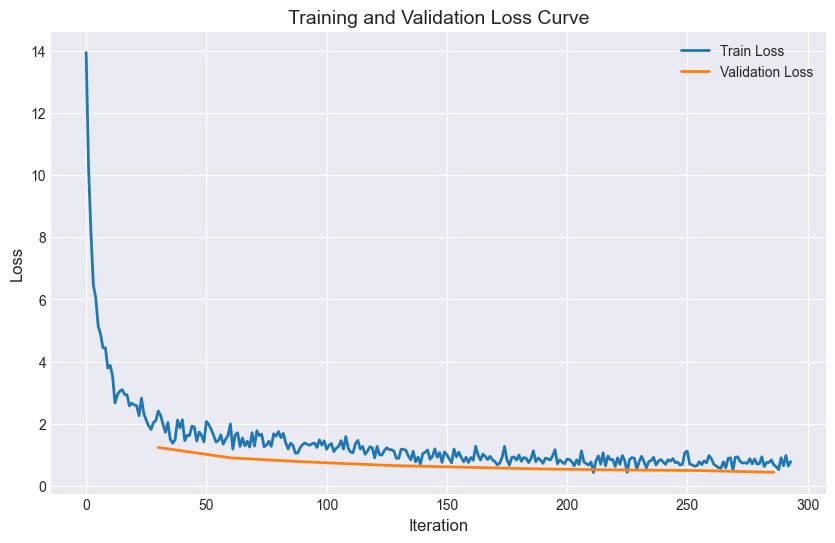

Figure saved as MNIST_result/MLP3_(512,256)_relu_L2-0.0_lr-0.05_augment=True_loss_curve.pdf


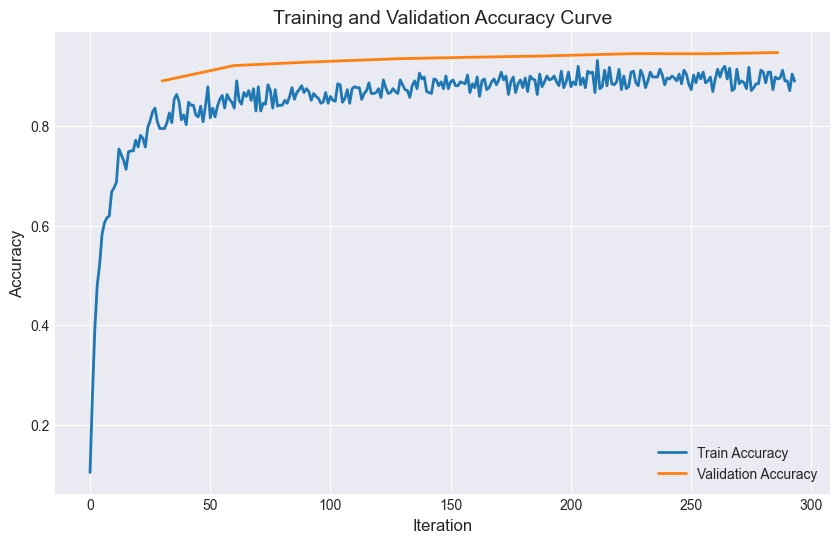

Figure saved as MNIST_result/MLP3_(512,256)_relu_L2-0.0_lr-0.05_augment=True_accuracy_curve.pdf


In [ ]:
# Plotting the loss curve
import os
import matplotlib.pyplot as plt
import numpy

def plot_figures(model_name):
    result = numpy.load(os.path.join('MNIST_result/results', f'{model_name}.npz'))
    x1 = numpy.arange(0, len(result['train_loss_iter']))
    train_loss = result['train_loss_iter']
    train_acc = result['train_acc_iter']

    print(result['val_loss_iter'])


    epoch_len = 50000
    if result['val_interval'].item() == 0:  # If no complete val_loss_iter, use val_loss_epoch instead, but need alignment
        # result['batch_size_till_iter'] is in shape (num_train, 2)
        end_point = result['batch_size_till_iter'].T[1]
        batch_size = result['batch_size_till_iter'].T[0]
        x2 = numpy.array([])
        for i in range(len(end_point)):
            iter_per_epoch = epoch_len // batch_size[i] + 1
            start_point = iter_per_epoch if i == 0 else end_point[i - 1] + iter_per_epoch
            x2 = numpy.concatenate((x2, numpy.arange(start_point, end_point[i], iter_per_epoch)))
        val_loss = result['val_loss_epoch']
        val_acc = result['val_acc_epoch']
    else:
        end_point = result['batch_size_till_iter'].T[1]
        batch_size = result['batch_size_till_iter'].T[0]
        interval = result['val_interval'].item()
        x2 = numpy.array([])
        for i in range(len(end_point)): 
            iter_per_epoch = epoch_len // batch_size[i] + 1
            for j in range(len(result['train_loss_epoch'])):  # How many epochs in this train      
                start = j * iter_per_epoch + interval if i == 0 else end_point[i - 1] + j * iter_per_epoch + interval
                end = end_point[i] if j == len(result['train_loss_epoch']) - 1 else (j + 1) * iter_per_epoch
                x2 = numpy.concatenate((x2, numpy.arange(start, end, interval)))
        val_loss = result['val_loss_iter']
        val_acc = result['val_acc_iter']

    plt.style.use('seaborn-v0_8-darkgrid')

    # --- Loss Curve ---
    plt.figure(figsize=(10, 6))
    plt.plot(x1, train_loss, label='Train Loss', linewidth=2)
    plt.plot(x2, val_loss, label='Validation Loss', linewidth=2)
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training and Validation Loss Curve', fontsize=14)
    plt.legend(loc='upper right', fontsize=10)
    f = f'MNIST_result/{model_name}_loss_curve.pdf'
    plt.savefig(f, bbox_inches='tight')
    plt.show()
    print(f'Figure saved as {f}')

    # --- Accuracy Curve ---
    plt.figure(figsize=(10, 6))
    plt.plot(x1, train_acc, label='Train Accuracy', linewidth=2)
    plt.plot(x2, val_acc, label='Validation Accuracy', linewidth=2)
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Training and Validation Accuracy Curve', fontsize=14)
    plt.legend(loc='lower right', fontsize=10)
    f = f'MNIST_result/{model_name}_accuracy_curve.pdf'
    plt.savefig(f, bbox_inches='tight')
    plt.show()
    print(f'Figure saved as {f}')


plot_figures(model_name='MLP3_(512,256)_relu_L2-0.0_lr-0.05_augment=True')

### Display the best model

In [7]:
import os
print(f'Best model: {best_model_name}')
with np.load(os.path.join('MNIST_result/results', f'{best_model_name}.npz')) as result:
    train_loss = result['train_loss_epoch']
    val_loss = result['val_loss_epoch']
    train_acc = result['train_acc_epoch']
    val_acc = result['val_acc_epoch']
print(f'Train loss: {train_loss[-1]:.3}  Val loss: {val_loss[-1]:.3}  Train acc: {train_acc[-1]:.3}  Val acc: {val_acc[-1]:.3}')
print(f'Hyperparameters: {best_hyperparams}')

Best model: MLP3_(512,256)_relu_L2-0.0_lr-0.05_augment=True
Train loss: 0.771  Val loss: 0.439  Train acc: 0.895  Val acc: 0.948
Hyperparameters: (512, 256, 'relu', 0.0, 0.05)


# ResNet

### Data Preparation

In [8]:
X_train_mytensor = MyDL.MyTensor(train_imgs[:50000], requires_grad=False)
y_train_mytensor = MyDL.MyTensor(train_labels[:50000], requires_grad=False)
X_val_mytensor = MyDL.MyTensor(train_imgs[50000:], requires_grad=False)
y_val_mytensor = MyDL.MyTensor(train_labels[50000:], requires_grad=False)
X_test_mytensor = MyDL.MyTensor(test_imgs, requires_grad=False)
y_test_mytensor = MyDL.MyTensor(test_labels, requires_grad=False)

augment = True
train_data = MyDL.data.mnist_dataset(X_train_mytensor, y_train_mytensor, augment=augment, augment_prob=0.5)
val_data = MyDL.data.mnist_dataset(X_val_mytensor, y_val_mytensor)
test_data = MyDL.data.mnist_dataset(X_test_mytensor, y_test_mytensor)

### Train model and Search the best hyperparameters

In [9]:
continue_if_exists = False
# highest_val_acc = 0
num_epochs = 30
model = None
optimizer = None
for lambda_L2 in [0.0]:#, 0.0001, 0.001]:
    for lr in [0.05]:#, 0.01, 0.001]:
        if model is not None:
            model.empty()
            model = None
        if optimizer is not None:
            optimizer.empty()
            optimizer = None
        gc.collect()
        pool = np.get_default_memory_pool()
        np.get_default_memory_pool().free_all_blocks()

        model_name = f'Resnet_L2-{lambda_L2}_lr-{lr}_augment={augment}'
        print(f'model: {model_name}')
        model = MyDL.sample_networks.ResNetMNIST()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.params, lr=lr, decay_rate=0.2)
        
        model_runner = MyDL.runner(model, model_name, optimizer, criterion, batch_size=256)

        result = model_runner.train(train_data, val_data, num_epochs, lambda_L2=0.0, result_path='MNIST_result/results', model_path='MNIST_result/model_params',continue_if_exists=continue_if_exists, val_interval=30)

        # if result['val_acc_epoch'][-1] > highest_val_acc:
        #     highest_val_acc = result['val_acc_epoch'][-1]
        #     best_model_name = model_name
        #     best_hyperparams = (hidden_size1, hidden_size2, activ_func, lambda_L2, lr)

model: Resnet_L2-0.0_lr-0.05_augment=True
iter 50		 loss 8.546
iter 100		 loss 5.301
iter 150		 loss 4.951
Epoch 1/30. Training Loss:   6.769 	 Accuracy: 0.117
            Validation Loss: 4.877 	 Accuracy: 0.147
iter 50		 loss 5.067
iter 100		 loss 3.828
iter 150		 loss 2.997
Epoch 2/30. Training Loss:   4.079 	 Accuracy: 0.149
            Validation Loss: 5.099 	 Accuracy: 0.041
iter 50		 loss 4.128
iter 100		 loss 4.317
iter 150		 loss 3.350
Epoch 3/30. Training Loss:   3.542 	 Accuracy: 0.181
            Validation Loss: 3.290 	 Accuracy: 0.170
iter 50		 loss 2.770
iter 100		 loss 2.563
iter 150		 loss 2.079
Epoch 4/30. Training Loss:   2.539 	 Accuracy: 0.231
            Validation Loss: 1.848 	 Accuracy: 0.342
iter 50		 loss 2.013


KeyboardInterrupt: 